### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 10 мая 2021, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 10 мая, -4 балла после 08:30 17 мая, -6 баллов после 08:30 24 мая, -8 баллов после 08:30 31 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

Ваше решение тут

Общий вид таргетов:
\begin{equation}
-\dfrac{\partial L}{\partial F}(F_{k-1}(x_i), y_i)
\end{equation}

Для MSE:
\begin{equation}
-\dfrac{\partial L}{\partial F}(F_{k-1}(x_i), y_i) = 2 \cdot (y_i - F_{k-1})
\end{equation}
Для экспоненциальной функции потерь:
\begin{equation}
-\dfrac{\partial L}{\partial F}(F_{k-1}(x_i), y_i) = y_i \cdot exp( -F_{k-1} y_i)
\end{equation}
Для логистической функции потерь:
\begin{equation}
-\dfrac{\partial L}{\partial F}(F_{k-1}(x_i), y_i) = \dfrac{y_i \cdot exp( -F_{k-1} y_i)}{1 + exp( -F_{k-1} y_i)}
 =  \dfrac{y_i}{1 + \exp(F_{k-1}y_i)}
 \end{equation}

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [2]:
import numpy as np

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
class MyGradientBoostingClassifier:

    def __init__(self, loss = 'mse', learning_rate = 0.1, n_estimators = 35, 
                 colsample = 0.9, subsample = 0.9, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        colsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        if loss == 'mse':
            self.lossfunc ='mse'
        elif loss == 'exp':
            self.lossfunc = 'exp'
        elif loss == 'log':
            self.lossfunc = 'log'  
        self.lrate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.args = args
        self.kwargs = kwargs
        self.my_models = []
 
    
    def fit(self, X, y, base_model=DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        
        
        self.init_model = init_model
        if init_model is None:
            model = base_model(*self.args, **self.kwargs)
            model.fit(X, y)
            self.my_models.append(model)
        elif init_model == 'SVM':
            model = SVC()
            model.fit(X, y)
            self.my_models.append(model)
        elif init_model == 'LinearRegression':
            model = LinearRegression()
            model.fit(X, y)
            self.my_models.append(model)
        elif init_model == 'RF':
            model = RandomForestClassifier()
            model.fit(X, y)
            self.my_models.append(model)
        
        features_count = int(X.shape[1] * self.colsample ) 
        self.features = np.zeros( (self.n_estimators, features_count) , dtype = int)
        sample_count = int( X.shape[0] * self.subsample )
        for i in range (1, self.n_estimators):
            model = base_model(*self.args, **self.kwargs)
            sample = np.random.choice(X.shape[0], sample_count , replace=False)
            self.features[i] = np.random.choice(X.shape[1], features_count, replace=False)           
            X_train = X[sample]
            prediction = self.predict(X_train)
            y_train = np.zeros(y[sample].shape[0], dtype = int)
            if self.lossfunc == 'mse':
                y_train = 2 * (y[sample] - prediction )
            elif self.lossfunc == 'exp':
                y_train = y[sample] * np.exp(-prediction * y[sample])
            elif self.lossfunc == 'log':
                y_train = y[sample] / (1 + np.exp(prediction * y[sample]))
            model.fit(X_train[:, self.features[i]], y_train)
            self.my_models.append(model)
          
                    
    def predict(self, X):
        prediction = self.my_models[0].predict(X).astype(float)
        for i in range(1, len(self.my_models)):
            prediction += self.lrate * self.my_models[i].predict(X[:, self.features[i]]).astype(float)
        if self.lossfunc == 'mse':
            prediction = prediction.astype(int)
        else:
            prediction[prediction < 0] = -1
            prediction[prediction >= 0] = 1
        return prediction   

In [4]:
my_clf = MyGradientBoostingClassifier(max_depth=5)
clf = GradientBoostingClassifier(max_depth = 5)

In [5]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [6]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.9444444444444444
0.9444444444444444


Скор сравним с sklearn реализацией GradientBoostingClassifier
Однако, для уверенности сделаю train_test_split и проверю скор ещё 25 раз

In [23]:
sklearn_scores = []
scores = []
for i in tqdm(range(25)):
    X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)
    my_clf = MyGradientBoostingClassifier(loss='mse', max_depth=5, n_estimators=35, learning_rate = 0.1)
    my_clf.fit(X_train, y_train, base_model = DecisionTreeRegressor)
    scores.append(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))    
    sklrn_clf = DecisionTreeRegressor(max_depth=5)
    sklrn_clf.fit(X_train, y_train)
    sklearn_scores.append(accuracy_score(y_pred = clf.predict(X_test).astype(int),y_true = y_test))  

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 12.73it/s]


Результат моей реализации:

In [24]:
scores = np.array(scores)
scores.mean()

0.9533333333333335

Результат реализации sklearn:

In [25]:
sklearn_scores = np.array(sklearn_scores)
sklearn_scores.mean()

0.9933333333333334

Как видно, моя реализация не уступает по качеству на таких тестировочных данных, как датасет с вином.
Но пойдём дальше и рассмотрим датасет покрупнее

## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [26]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [27]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


Находим оптимальное число n_estimators для дальнейшего использования

Я попытался для данного теста воспользоваться KFold и при помощи него произвести кросс-валидацию,
помимо основного train_test_split

Однако, производительность моего ноутбука и процессора просто не вытягивает такой тест
и эту идею я оставил в данном случае

In [29]:
n_estimators = np.arange(1, 100, 1)
scores = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

for i in tqdm(range(99)):
    my_clf = MyGradientBoostingClassifier(loss='mse', n_estimators = n_estimators[i], learning_rate=0.1, max_depth=3)
    my_clf.fit(X_train, y_train, base_model=DecisionTreeRegressor)
    scores.append(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [06:32<00:00,  3.96s/it]


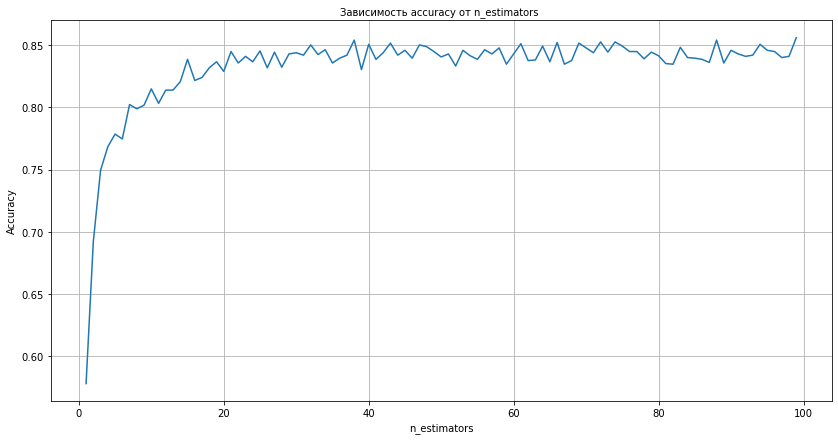

In [30]:
scores = np.array(scores)
fig  = plt.figure(figsize=(14, 7))
ax = plt.subplot(111)
plt.plot(n_estimators, scores)
plt.title('Зависимость accuracy от n_estimators ', fontsize=10)
ax.grid()
ax.set_xlabel('n_estimators')
ax.set_ylabel('Accuracy')
plt.show()

In [31]:
print(sorted(scores, reverse=True)[:5])

[0.8561046511627907, 0.8541666666666666, 0.8541666666666666, 0.8527131782945736, 0.8527131782945736]


In [32]:
scores

array([0.57800388, 0.69234496, 0.7495155 , 0.76841085, 0.77858527,
       0.7747093 , 0.80232558, 0.79893411, 0.80184109, 0.81492248,
       0.80329457, 0.81395349, 0.81395349, 0.82073643, 0.83866279,
       0.82170543, 0.82412791, 0.83187984, 0.83672481, 0.82897287,
       0.84496124, 0.83575581, 0.84108527, 0.83672481, 0.84544574,
       0.83187984, 0.84447674, 0.83236434, 0.84302326, 0.84399225,
       0.84205426, 0.8502907 , 0.84253876, 0.84641473, 0.83575581,
       0.83963178, 0.84205426, 0.85416667, 0.83042636, 0.85077519,
       0.83866279, 0.84399225, 0.85174419, 0.84205426, 0.84593023,
       0.83963178, 0.8502907 , 0.84883721, 0.84496124, 0.84060078,
       0.84302326, 0.83333333, 0.84593023, 0.84156977, 0.83866279,
       0.84641473, 0.84302326, 0.84786822, 0.83478682, 0.84302326,
       0.85125969, 0.8376938 , 0.83817829, 0.84932171, 0.83672481,
       0.85222868, 0.83478682, 0.8376938 , 0.85174419, 0.84786822,
       0.84399225, 0.85271318, 0.84447674, 0.85271318, 0.84932

Самые лучшие результаты -это когда n_estimators = 99, 89 и 39

В силу того, что особо сильных отличий в скорах нет, возьму n_estimators для валидации = 39 и проведу
дальнейшую валидацию, иначе при других чуть более оптимальных значениях считаться это всё будет прилично по времени.

Возьму KFold валидацию по 5 фолдам на все оставшиеся параметры.

Итак, мы взяли n_estimators = 39. Теперь определим наилучший loss вместе с learning rate.
Проведём эту валидацию одновременно

In [33]:
Folds = KFold(n_splits = 5)
learning_rates = np.linspace(0.1, 1, 10)
scores_mse = []
res = 0
for i in tqdm(range(10)):
    for train_id , test_id in Folds.split(X):
        X_train = X[train_id]
        X_test  = X[test_id]
        y_train = y[train_id]
        y_test = y[test_id]
        my_clf = MyGradientBoostingClassifier(loss='mse', learning_rate=learning_rates[i], max_depth=3, n_estimators=39)
        my_clf.fit(X_train, y_train, base_model=DecisionTreeRegressor)
        res += accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)
    res = res/5
    scores_mse.append(res)
    res = 0

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:45<00:00, 10.51s/it]


In [34]:
scores_mse

[0.7984496124031006,
 0.7952034883720931,
 0.787451550387597,
 0.7749031007751939,
 0.7902131782945736,
 0.7582364341085273,
 0.7478682170542635,
 0.7382267441860465,
 0.7031976744186046,
 0.6763565891472868]

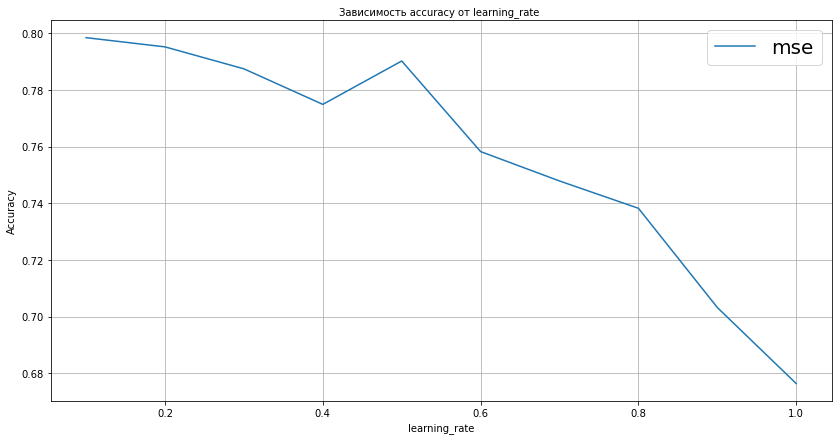

In [35]:
scores_mse = np.array(scores_mse)
fig  = plt.figure(figsize=(14, 7))
ax = plt.subplot(111)
plt.plot(learning_rates, scores_mse, label = 'mse')
plt.title('Зависимость accuracy от learning_rate ', fontsize=10)
ax.grid()
ax.set_xlabel('learning_rate')
ax.set_ylabel('Accuracy')
plt.legend(fontsize=20)
plt.show()

Теперь для проверки экспоненциальной и логистической функции сделаем смену таргета классификации на (1,-1)

In [36]:
y[y == 0] = -1

In [37]:
Folds = KFold(n_splits = 5)
learning_rates = np.linspace(0.1, 1, 10)
scores_exp = []
res = 0
for i in tqdm(range(10)):
    for train_id , test_id in Folds.split(X):
        X_train = X[train_id]
        X_test  = X[test_id]
        y_train = y[train_id]
        y_test = y[test_id]
        my_clf = MyGradientBoostingClassifier(loss='exp', learning_rate=learning_rates[i], max_depth=3, n_estimators=24)
        my_clf.fit(X_train, y_train, base_model=DecisionTreeRegressor)
        res += accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)
    res = res/5
    scores_exp.append(res)
    res = 0

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:53<00:00,  5.31s/it]


In [38]:
scores_exp

[0.8168604651162792,
 0.8150193798449612,
 0.8157461240310078,
 0.8281007751937984,
 0.8272771317829457,
 0.818701550387597,
 0.8211240310077519,
 0.8237403100775194,
 0.8189922480620154,
 0.8283914728682171]

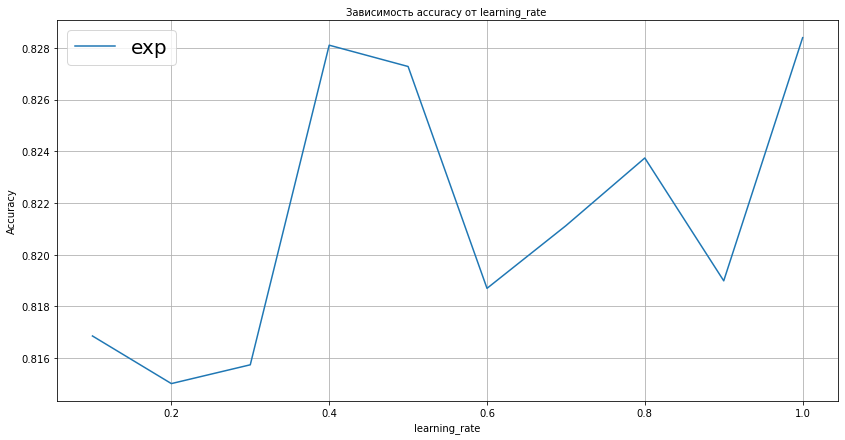

In [39]:
scores_exp = np.array(scores_exp)
fig  = plt.figure(figsize=(14, 7))
ax = plt.subplot(111)
plt.plot(learning_rates, scores_exp, label = 'exp')
plt.title('Зависимость accuracy от learning_rate ', fontsize=10)
ax.grid()
ax.set_xlabel('learning_rate')
ax.set_ylabel('Accuracy')
plt.legend(fontsize=20)
plt.show()

In [40]:
Folds = KFold(n_splits = 5)
learning_rates = np.linspace(0.1, 1, 10)
scores_log = []
res = 0
for i in tqdm(range(10)):
    for train_id , test_id in Folds.split(X):
        X_train = X[train_id]
        X_test  = X[test_id]
        y_train = y[train_id]
        y_test = y[test_id]
        my_clf = MyGradientBoostingClassifier(loss='log', learning_rate=learning_rates[i], max_depth=3, n_estimators=39)
        my_clf.fit(X_train, y_train, base_model=DecisionTreeRegressor)
        res += accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)
    res = res/5
    scores_log.append(res)
    res = 0

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:43<00:00, 10.34s/it]


In [41]:
scores_log

[0.8072189922480619,
 0.8075096899224805,
 0.8075581395348838,
 0.811482558139535,
 0.808187984496124,
 0.8085755813953488,
 0.8076065891472869,
 0.8142926356589146,
 0.7992248062015503,
 0.8134205426356589]

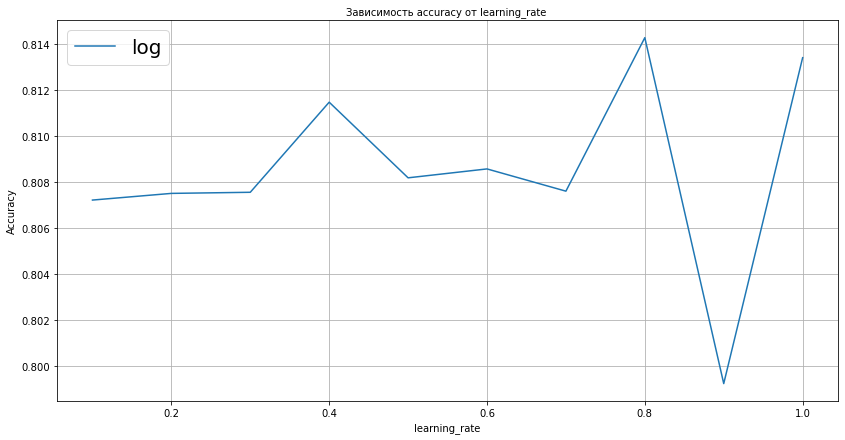

In [42]:
scores_log = np.array(scores_log)
fig  = plt.figure(figsize=(14, 7))
ax = plt.subplot(111)
plt.plot(learning_rates, scores_log, label = 'log')
plt.title('Зависимость accuracy от learning_rate ', fontsize=10)
ax.grid()
ax.set_xlabel('learning_rate')
ax.set_ylabel('Accuracy')
plt.legend(fontsize=20)
plt.show()

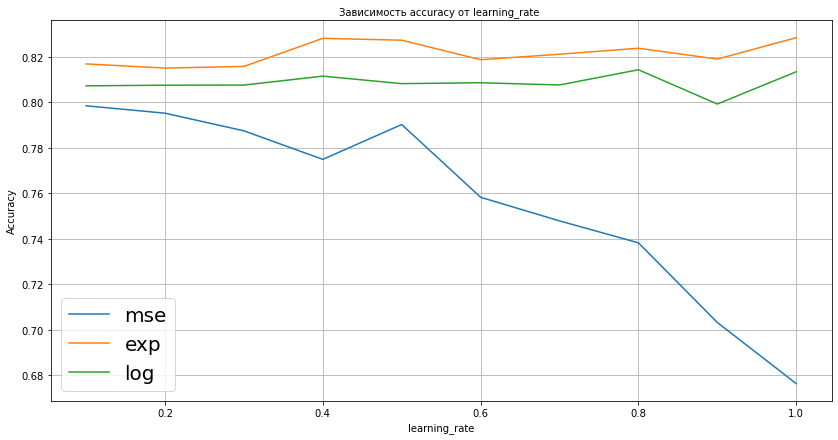

In [43]:
fig  = plt.figure(figsize=(14, 7))
ax = plt.subplot(111)
plt.plot(learning_rates, scores_mse, label='mse')
plt.plot(learning_rates, scores_exp, label='exp')
plt.plot(learning_rates, scores_log, label='log')
plt.title('Зависимость accuracy от learning_rate ', fontsize=10)
ax.grid()
ax.set_xlabel('learning_rate')
ax.set_ylabel('Accuracy')
plt.legend(fontsize=20)
plt.show()

Таким образом, возьмём экспоненциальный loss, а learning_rate = 0.4

In [44]:
depth = np.arange(1, 15)
scores_depth = []
res = 0
Folds = KFold(n_splits = 5)
for i in tqdm(range(14)):
    for train_id , test_id in Folds.split(X):
        X_train = X[train_id]
        X_test  = X[test_id]
        y_train = y[train_id]
        y_test = y[test_id]
        my_clf = MyGradientBoostingClassifier(loss='exp', learning_rate = 0.4, max_depth =  depth[i], n_estimators=39)
        my_clf.fit(X_train, y_train, base_model=DecisionTreeRegressor)
        res += accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)
    res = res/5
    scores_depth.append(res)
    res = 0

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [04:57<00:00, 21.22s/it]


In [45]:
scores_depth

[0.7612403100775194,
 0.8159883720930232,
 0.8330910852713178,
 0.8343507751937984,
 0.8332848837209301,
 0.8349806201550388,
 0.8256782945736434,
 0.8351259689922481,
 0.8293120155038759,
 0.8342054263565892,
 0.8357558139534884,
 0.8324127906976745,
 0.836482558139535,
 0.8320251937984496]

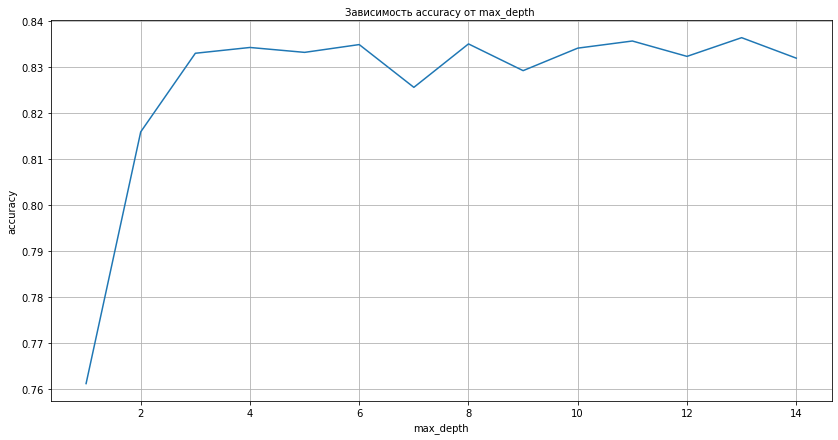

In [46]:
scores_depth = np.array(scores_depth)
fig  = plt.figure(figsize=(14, 7))
ax = plt.subplot(111)
plt.plot(depth, scores_depth)
plt.title('Зависимость accuracy от max_depth ', fontsize=10)
ax.grid()
ax.set_xlabel('max_depth')
ax.set_ylabel('accuracy')
plt.show()

Как видно по полученному результату, самое оптимальное будет max_depth = 13.
Я возьму max_depth = 8, он немного уступает в точности, однако я сомневаюсь, что при глубине = 13
мой компьютер сможет это всё  посчитать, особенно в случаях, когда нужно будет использовать Random Forest

Осталось провалидировать оптимальные subsample и colsample

In [47]:
subsample = [0.7, 0.8, 0.9, 1]
colsample = [0.7, 0.8, 0.9, 1]
colsubscores = []
res = 0
restuple = ()
Folds = KFold(n_splits = 5)
for col in tqdm(colsample):
    for sub in tqdm(subsample):
        for train_id , test_id in Folds.split(X):
            X_train = X[train_id]
            X_test  = X[test_id]
            y_train = y[train_id]
            y_test = y[test_id]
            my_clf = MyGradientBoostingClassifier(loss='exp', learning_rate = 0.4, max_depth = 8,
                                                   colsample = col, subsample = sub,n_estimators=39)
            my_clf.fit(X_train, y_train, base_model=DecisionTreeRegressor)
            res += accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)
        res = res/5
        restuple = (col,sub,res)
        colsubscores.append(restuple)
        res = 0

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [04:51<00:00, 72.76s/it]


In [48]:
colsubscores

[(0.7, 0.7, 0.8244670542635658),
 (0.7, 0.8, 0.8270348837209301),
 (0.7, 0.9, 0.8197189922480621),
 (0.7, 1, 0.8240794573643411),
 (0.8, 0.7, 0.8289244186046512),
 (0.8, 0.8, 0.8390503875968992),
 (0.8, 0.9, 0.8273255813953488),
 (0.8, 1, 0.830717054263566),
 (0.9, 0.7, 0.8376453488372093),
 (0.9, 0.8, 0.8356104651162791),
 (0.9, 0.9, 0.834205426356589),
 (0.9, 1, 0.8382751937984496),
 (1, 0.7, 0.832170542635659),
 (1, 0.8, 0.8340116279069768),
 (1, 0.9, 0.8359980620155039),
 (1, 1, 0.8299418604651162)]

Итак, возьму colsample = 0.8 и subsample = 0.8 ( результат 0.8390503875968992 шестой строчки )

Итоговый результат выйдет вот таким:

In [57]:
my_clf = MyGradientBoostingClassifier(loss='exp', n_estimators=39, learning_rate=0.4, max_depth=8,
                                      subsample=0.8, colsample=0.8)
my_clf.fit(X_train, y_train, base_model=DecisionTreeRegressor)
pred = my_clf.predict(X_test)
accuracy_score(pred, y_test)

0.8253391472868217

Однако же, все эти параметры я настраивал на n_estimators=39, чтобы справиться с временем работы.
Что, если при таких параметрах сделать ещё раз валидацию на n_estimators?
И проверить score

In [58]:
y[y == 0] = -1

In [63]:
n_estimators = np.arange(1, 100, 1)
scores = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

for i in tqdm(range(99)):
    my_clf = MyGradientBoostingClassifier(loss='exp', n_estimators= n_estimators[i], learning_rate=0.4, max_depth=8,
                                      subsample=0.8, colsample=0.8)
    my_clf.fit(X_train, y_train, base_model=DecisionTreeRegressor)
    scores.append(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [08:20<00:00,  5.05s/it]


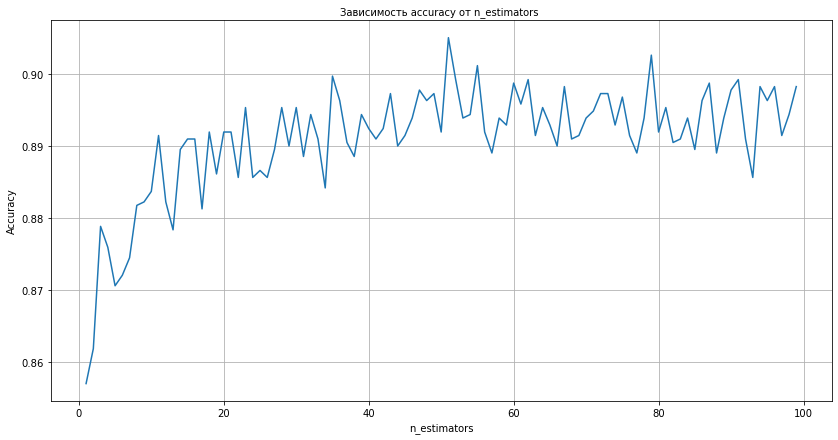

In [64]:
scores = np.array(scores)
fig  = plt.figure(figsize=(14, 7))
ax = plt.subplot(111)
plt.plot(n_estimators, scores)
plt.title('Зависимость accuracy от n_estimators ', fontsize=10)
ax.grid()
ax.set_xlabel('n_estimators')
ax.set_ylabel('Accuracy')
plt.show()

In [67]:
print(sorted(scores, reverse=True)[:5])

[0.9050387596899225, 0.9026162790697675, 0.9011627906976745, 0.8997093023255814, 0.8992248062015504]


In [68]:
scores

array([0.85707364, 0.8619186 , 0.87887597, 0.87596899, 0.87063953,
       0.87209302, 0.8745155 , 0.88178295, 0.88226744, 0.88372093,
       0.89147287, 0.88226744, 0.87839147, 0.88953488, 0.89098837,
       0.89098837, 0.88129845, 0.89195736, 0.88614341, 0.89195736,
       0.89195736, 0.88565891, 0.89534884, 0.88565891, 0.88662791,
       0.88565891, 0.88953488, 0.89534884, 0.89001938, 0.89534884,
       0.88856589, 0.89437984, 0.89098837, 0.88420543, 0.8997093 ,
       0.89631783, 0.89050388, 0.88856589, 0.89437984, 0.89244186,
       0.89098837, 0.89244186, 0.89728682, 0.89001938, 0.89147287,
       0.89389535, 0.89777132, 0.89631783, 0.89728682, 0.89195736,
       0.90503876, 0.89922481, 0.89389535, 0.89437984, 0.90116279,
       0.89195736, 0.88905039, 0.89389535, 0.89292636, 0.89874031,
       0.89583333, 0.89922481, 0.89147287, 0.89534884, 0.89292636,
       0.89001938, 0.89825581, 0.89098837, 0.89147287, 0.89389535,
       0.89486434, 0.89728682, 0.89728682, 0.89292636, 0.89680

In [69]:
scores = np.array(scores)
np.max(scores)

0.9050387596899225

In [70]:
np.argmax(scores)

50

Таким образом, при таких параметрах наиболее оптимальным будет n_estimators = 51

Итоговая реализация и скор выглядят так :

In [73]:
my_clf = MyGradientBoostingClassifier(loss='exp', n_estimators=51, learning_rate=0.4, max_depth=8,
                                      subsample=0.8, colsample=0.8)
my_clf.fit(X_train, y_train, base_model=DecisionTreeRegressor)
pred = my_clf.predict(X_test)
accuracy_score(pred, y_test)

0.8900193798449613

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [74]:
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC

In [75]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)
y = (y > 2.0).astype(int)
print(X.shape, y.shape)
y[y == 0] = -1

(20640, 8) (20640,)


Стратегия №1 - base_model = RF

In [76]:
my_clf = MyGradientBoostingClassifier(loss='exp', n_estimators=51, learning_rate=0.4, max_depth=8,
                                      subsample=0.8, colsample=0.8)
my_clf.fit(X_train, y_train, base_model=RandomForestRegressor)
pred = my_clf.predict(X_test)
accuracy_score(pred, y_test)

0.9021317829457365

Как ни странно, данная стратегия дала профит и увеличила наш скор.

Хотя по хорошему, мы и производим бустинг для того, чтобы избавиться от независимости моделей,
ведь при бустинге у нас каждая новая модель учится на ошибках предыдущих.

Тем не менее - скор стал выше

Стратегия №2 - N бустингов

In [72]:
subsample = 0.8
colsample = 0.8
Num_of_trees = 10
res = 0
prediction = np.zeros(y_test.shape[0])

features_count = int(X_train.shape[1] * colsample) 
sample_count = int( X_train.shape[0] * subsample)

for i in tqdm(range(10)):
    sample = np.random.choice(X_train.shape[0], sample_count, replace=False)
    features = np.random.choice(X_train.shape[1], features_count, replace=False)
    my_clf = MyGradientBoostingClassifier(loss='exp', n_estimators=51, learning_rate=0.4, max_depth=8)
    my_clf.fit(X_train[sample][:, features], y_train[sample], base_model=DecisionTreeRegressor)
    res = my_clf.predict(X_test[:, features])
    prediction += res
    
prediction = (prediction / 10)
prediction[prediction < 0] = -1
prediction[prediction >= 0] = 1
accuracy_score(prediction, y_test)

0.8958333333333334

Скор также стал выше, ведь много моделей голосованием дают лучшее качество, чем одна большая модель

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [ ]:
my_clf = MyGradientBoostingClassifier(loss='exp', n_estimators=51, learning_rate=0.4, max_depth=8,
                                      subsample=0.8, colsample=0.8)

In [80]:
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC

In [81]:
y[y == 0] = -1

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
clf = MyGradientBoostingClassifier(loss ='exp', 
                                   n_estimators=51, 
                                   learning_rate=0.4,
                                   max_depth= 8,
                                   colsample=0.8,
                                   subsample= 0.8)
clf.fit(X_train, y_train, base_model =DecisionTreeRegressor, init_model = 'LinearRegression')
y_pred = clf.predict(X_test)
accuracy_score(y_pred, y_test)

0.8846899224806202

Как мы видим, линейная регрессия даёт примерно такой же скор.

Хотя, если задуматься, ведь довольно-таки удобно использовать в качестве начальной модели именно линейную регрессию

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
clf = MyGradientBoostingClassifier(loss ='exp', 
                                   n_estimators=51, 
                                   learning_rate=0.4,
                                   max_depth= 8,
                                   colsample=0.8,
                                   subsample= 0.8)
clf.fit(X_train, y_train, base_model =DecisionTreeRegressor, init_model = 'SVM')
y_pred = clf.predict(X_test)
accuracy_score(y_pred, y_test)

0.8895348837209303

SVM даёт не самую лучшую точность, да ещё и  довольно долго работает

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
clf = MyGradientBoostingClassifier(loss ='exp', 
                                   n_estimators=51, 
                                   learning_rate=0.4,
                                   max_depth= 8,
                                   colsample=0.8,
                                   subsample= 0.8)
clf.fit(X_train, y_train, base_model =DecisionTreeRegressor, init_model = 'RF')
y_pred = clf.predict(X_test)
accuracy_score(y_pred, y_test)

0.8827519379844961

Random Forest неплох, работает недолго, но он практически равносилен предыдущим стратегиям BagBoo или BooBag

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ



Приятная домашка.

В отличие от предыдущей на деревья эта доставила намного больше удовольствия